In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm

%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

# Отбираем данные с '2022-12-02' по '2022-12-08' для 1 и 2 экспериментальной группы.

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [3]:
# проверяем, равны ли группы по числу пользователей - более-менее равны
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [4]:
# поделим на две группы
group_1 = df[df.exp_group == 1]
group_2 = df[df.exp_group == 2]

<AxesSubplot:xlabel='ctr', ylabel='Count'>

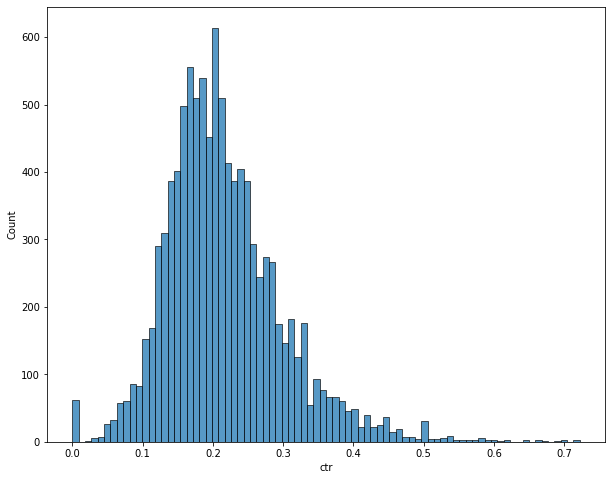

In [5]:
# "посмотрим глазами" распределение CTR - 1 группа
plt.figure(figsize=(10, 8))
sns.histplot(data = group_1, x='ctr')

<AxesSubplot:xlabel='ctr', ylabel='Count'>

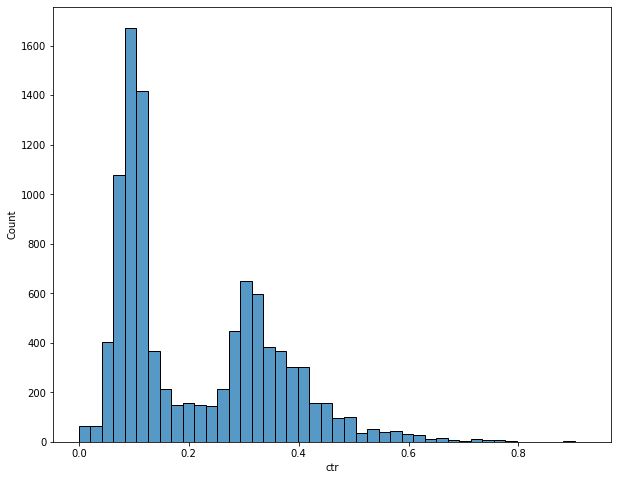

In [6]:
# у второй группы распределение ещё более далеко от нормального, скошено влево
plt.figure(figsize=(10, 8))
sns.histplot(data = group_2, x='ctr')

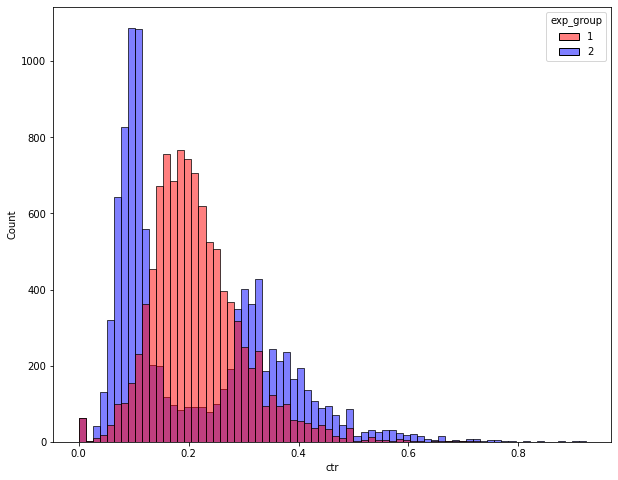

In [7]:
# на одном графике - визуально сильно отличаются друг от друга - но какое лучше?
plt.figure(figsize=(10, 8))
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

# T-критерий и тест Манна-Уитни

In [8]:
# t-test
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

T-test показал, что нет стат. значимых различий. Возможно, тест сработал некорректно, так как:
1. Распределение 2-ой группы очень сильно скошено.

2. В распределении очень высока вероятность больших по модулю отклонений (см. ниже). Например, во второй группе ctr при моде в 0.33 // медиане в 0.14 // среднем в 0.21 есть 39 выбросов, где ctr >= 0.7.

In [13]:
f'Вторая группа: мода = {group_2.ctr.mode()[0].round(2)}, медиана = {group_2.ctr.median().round(2)}, среднее = {group_2.ctr.mean().round(2)}, количество пользователей с ctr >= 0.7 - {group_2[group_2.ctr >= 0.7].count()[0]}'

'Вторая группа: мода = 0.33, медиана = 0.14, среднее = 0.21, количество пользователей с ctr >= 0.7 - 39'

In [14]:
f'Первая группа: мода = {group_1.ctr.mode()[0].round(2)}, медиана = {group_1.ctr.median().round(2)}, среднее = {group_1.ctr.mean().round(2)}, количество пользователей с ctr >= 0.7 - {group_1[group_1.ctr >= 0.7].count()[0]}'

'Первая группа: мода = 0.2, медиана = 0.2, среднее = 0.22, количество пользователей с ctr >= 0.7 - 5'

In [38]:
# тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [15]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 56.85 % случаев A > B. Должно получиться около 50%


Тест Манна-Уитни, напротив, показал, что стат. значимые различия есть. Причём в 1 группе (контроль) CTR больше?

# Сглаженный CTR

In [16]:
# копируем функцию для расчёта сглаженного ctr =)
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [17]:
# считаем общегрупповой ctr для каждой группы
global_ctr_1 = group_1.likes.sum() / group_1.views.sum()
global_ctr_2 = group_2.likes.sum() / group_2.views.sum()

/tmp/ipykernel_46/394765823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_1['smothed_ctr'] = df.apply(


<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

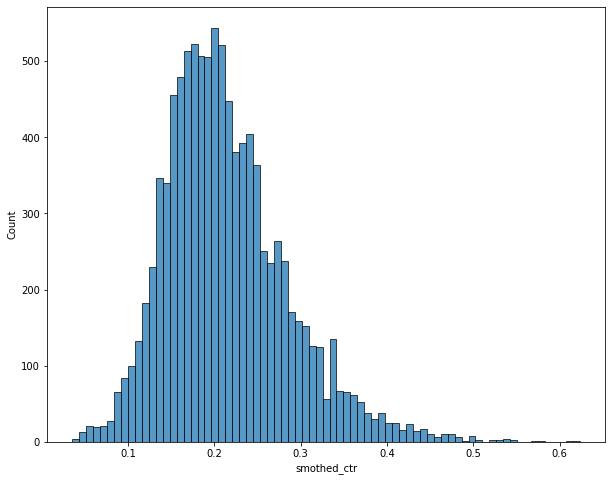

In [23]:
# смотрим на распределение сглаженного ctr для 1 группы
group_1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
plt.figure(figsize=(10, 8))
sns.histplot(group_1.smothed_ctr, 
             kde = False)

/tmp/ipykernel_46/3185126420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_2['smothed_ctr'] = df.apply(


<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

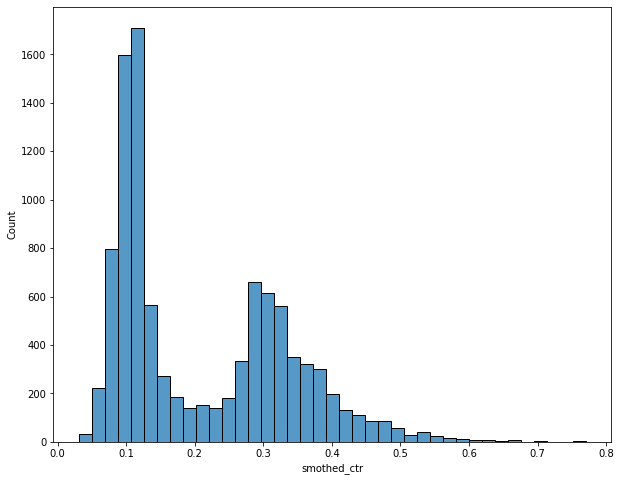

In [24]:
# смотрим на распределение сглаженного ctr для 2 группы
group_2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
plt.figure(figsize=(10, 8))
sns.histplot(group_2.smothed_ctr, 
             kde = False)

In [20]:
# t-test для сглаженного ctr
stats.ttest_ind(group_1.smothed_ctr,
                group_2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [25]:
# тест Манна-Уитни для сглаженного ctr
stats.mannwhitneyu(group_1.smothed_ctr, 
                   group_2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

T-test всё равно отрицает различия между группами (но p-value стало меньше), а тест Манна-Уитни допускает стат. значимые различия между группами ещё более уверенно. Пока для меня нет ясности, привёл ли новый алгоритм к увеличению CTR.

# Пуассоновский бутстреп для подсчета разницы в CTR

<AxesSubplot:ylabel='Count'>

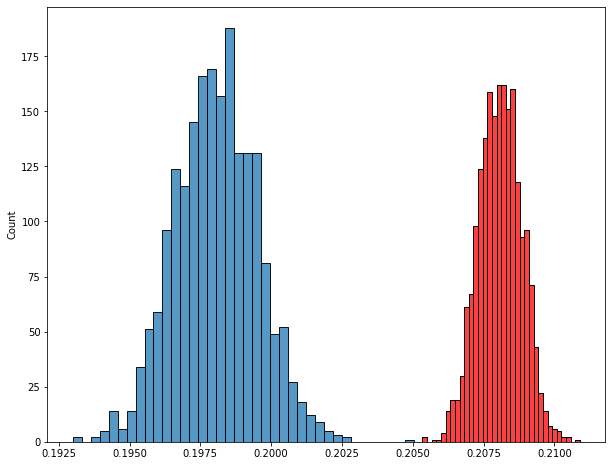

In [26]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2



likes1 = group_1.likes.to_numpy()
views1 = group_1.views.to_numpy()
likes2 = group_2.likes.to_numpy()
views2 = group_2.views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
plt.figure(figsize=(10, 8))
sns.histplot(ctr1, color='red')
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

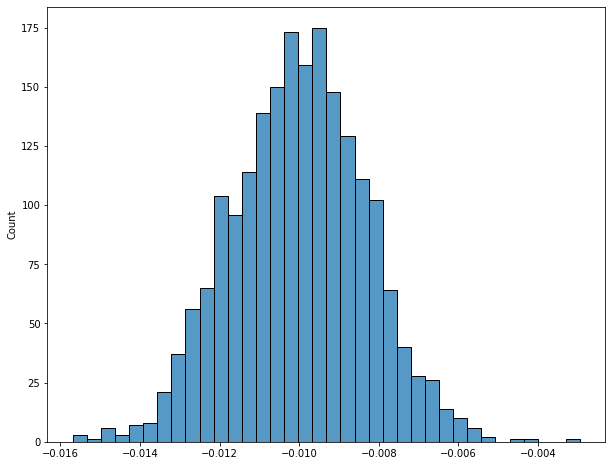

In [27]:
# Разница между глобальными CTR - отрицательная!
plt.figure(figsize=(10, 8))
sns.histplot(ctr2 - ctr1)

Пуассоновский бутстреп показал не только разницу между групповыми ctr, но и то, что 2 группа имеет меньший ctr, чем 1. За счёт достаточного количества пользователей в группах удаётся сформировать репрезентативные подвыборки, глобальные ctr получились по гистограмме приближенными к нормальным, и наглядно видна разница между ними.

# Бакетное преобразование

In [29]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-12-02' and '2022-12-08'
        and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

In [30]:
df_bucket.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


In [31]:
# t-тест видит отличие

stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [32]:
# тест Манна-Уитни видит отличие
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

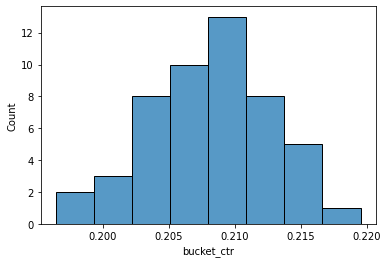

In [33]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

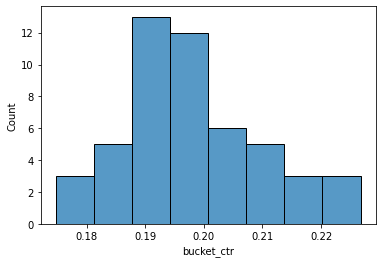

In [34]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_ctr)

# Выводы

*попытка не пытка*

<u>Почему тесты сработали так как сработали? Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.</u>

Распределение исходных данных не является нормальным, есть выбросы - представляется, что t-test именно поэтому мог сработать некорректно. При этом t-test на сглаженным ctr показал уже меньшее значение p-value, а по результатам бакетного преобразования (куда более успешно "нормализовавшем" данные) - показал, что есть высокая вероятность различия ctr в контрольной и тестовой группах.

Методы анализа, не привязанные к требованиям нормальности распределения данных и прочее говорят о различиях ctr. Отметим, что посредством Пуассоновского бутстрепа и графического воплощения его результатов разница эта видна наглядна и не говорит в пользу тестовой группы.

<u>Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.</u>

Не раскатывать. Разница есть, но в сторону понижения ctr.